<a href="https://colab.research.google.com/github/sudhanshu10on10/ds_-sudhanshu_ayer-/blob/main/altcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ===================== CONFIG =====================
TRADES_CSV = "/content/drive/MyDrive/bitcoin_data/Copy of historical_data.csv"
SENTI_CSV  = "/content/drive/MyDrive/bitcoin_data/Copy of fear_greed_index.csv"

# ===================== IMPORTS =====================
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

OUTDIR = Path("outputs"); OUTDIR.mkdir(exist_ok=True)

# ===================== HELPERS =====================
def parse_trade_time(df):
    df = df.copy()
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    if "timestamp" in df.columns:
        ts = pd.to_numeric(df["timestamp"], errors="coerce")
        if ts.dropna().median() > 1e12: ts = ts/1000.0  # ms->s
        df["ts"] = pd.to_datetime(ts, unit="s", utc=True)
    elif "timestamp_ist" in df.columns:
        df["ts"] = (pd.to_datetime(df["timestamp_ist"], dayfirst=True, errors="coerce")
                     .dt.tz_localize("Asia/Kolkata").dt.tz_convert("UTC"))
    else:
        raise ValueError("No timestamp column found.")
    return df

def _first(cols, cands):
    for c in cands:
        if c in cols: return c
    flat = {c: c.replace("_","") for c in cols}
    for c in cands:
        k = c.replace("_","")
        for col, f in flat.items():
            if f.startswith(k): return col
    return None

def clean_trades(df):
    df = df.copy(); cols = set(df.columns)
    price = _first(cols, ["execution","execution_price","price"])
    qty   = _first(cols, ["size_token","size_tokens","qty","size"])
    sizeu = _first(cols, ["size_usd","sizeusd","notional"])
    fee   = _first(cols, ["fee","fees"])
    side  = _first(cols, ["side"])
    oid   = _first(cols, ["order_id"])
    tid   = _first(cols, ["trade_id"])
    acct  = _first(cols, ["account"])
    coin  = _first(cols, ["coin","symbol"])
    ren = {}
    if price: ren[price]="price"
    if qty:   ren[qty]="qty"
    if sizeu: ren[sizeu]="size_usd"
    if fee:   ren[fee]="fee"
    if side:  ren[side]="side"
    if oid:   ren[oid]="order_id"
    if tid:   ren[tid]="trade_id"
    if acct:  ren[acct]="account"
    if coin:  ren[coin]="coin"
    df = df.rename(columns=ren)
    if "account" not in df.columns: df["account"]="acct_0"
    if "coin" not in df.columns: df["coin"]="BTC"

    for c in ["qty","price","fee","size_usd"]:
        if c in df.columns: df[c]=pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=["qty","price"])
    df = df[df["qty"]>0]
    df["side"]=df["side"].astype(str).str.upper().str.strip()
    df = df[df["side"].isin(["BUY","SELL"])]
    df = df.drop_duplicates(subset=["order_id","trade_id","ts"])
    df = df.sort_values(["account","coin","ts","order_id","trade_id"]).reset_index(drop=True)

    df["signed_qty"] = np.where(df["side"]=="BUY", df["qty"], -df["qty"])
    df["abs_notional"] = (df["size_usd"].abs()
                          if "size_usd" in df.columns and df["size_usd"].notna().any()
                          else (df["qty"].abs()*df["price"].abs()))

    # fee in USD; ignore negative rebates for KPI stability
    if "fee" not in df.columns: df["fee"]=0.0
    fee_raw = pd.to_numeric(df["fee"], errors="coerce").fillna(0.0)
    # If it's a rate, it should be small and positive
    looks_like_rate = (0 < np.nanmedian(fee_raw) < 0.02) and (fee_raw.max() <= 0.5)
    fee_value = fee_raw*df["abs_notional"] if looks_like_rate else fee_raw
    df["fee_value"] = np.clip(fee_value, 0, None)  # clamp rebates to 0 for fee%
    return df

def average_cost_engine(g):
    """Average-cost PnL with realized qty and realized notional on sells only."""
    pos=0.0; inv_cost=0.0; aep=np.nan
    realized_pnl=[]; pos_after=[]; aep_list=[]; invc=[]; realized_qty=[]; realized_notional=[]
    for _,r in g.iterrows():
        qty=r.signed_qty; px=r.price; fee=float(r.fee_value)
        if qty>0:  # BUY
            inv_cost += qty*px + fee
            pos += qty
            aep = inv_cost/pos if pos else np.nan
            realized_pnl.append(0.0); realized_qty.append(0.0); realized_notional.append(0.0)
        else:      # SELL
            close_qty = min(-qty, abs(pos)) if pos>0 else 0.0
            if close_qty>0:
                pnl = close_qty*(px - aep) - fee
                inv_cost -= close_qty*aep
                pos += qty
                if pos==0: inv_cost=0.0; aep=np.nan
                else: aep = inv_cost/pos
                realized_pnl.append(pnl); realized_qty.append(close_qty)
                # realized notional in USD for the portion actually closed
                trade_notional = (r.qty*r.price if "size_usd" not in g.columns else r.size_usd)
                realized_notional.append(trade_notional*(close_qty/r.qty))
            else:
                # flat-to-short or no inventory: count only fee as loss
                realized_pnl.append(-fee); realized_qty.append(0.0); realized_notional.append(0.0)
        pos_after.append(pos); aep_list.append(aep); invc.append(inv_cost)

    out=g.copy()
    out["position_after"]=pos_after
    out["aep"]=aep_list
    out["inventory_cost"]=invc
    out["realized_pnl"]=realized_pnl
    out["realized_qty"]=realized_qty
    out["realized_notional"]=realized_notional
    out["is_realized"]=out["realized_qty"]>0
    return out

def parse_sentiment(senti):
    s=senti.copy()
    s.columns=[c.strip().lower() for c in s.columns]
    s["ts_day"]=pd.to_datetime(pd.to_numeric(s["timestamp"], errors="coerce"), unit="s", utc=True).dt.floor("D")
    s=s.sort_values("ts_day")
    s["regime"]=s["classification"].str.lower().str.replace("extreme ","", regex=False).str.title()
    s.loc[~s["regime"].isin(["Fear","Neutral","Greed"]), "regime"]="Neutral"
    return s[["ts_day","value","regime"]]

def attach_sentiment(trades, senti):
    t=trades.sort_values("ts").copy(); s=senti.sort_values("ts_day")
    t["ts_day"]=t["ts"].dt.floor("D")
    j=pd.merge_asof(t.sort_values("ts_day"), s.rename(columns={"ts_day":"key"}).sort_values("key"),
                    left_on="ts_day", right_on="key", direction="backward", allow_exact_matches=True)\
       .drop(columns=["key"])
    j["ts"]=pd.to_datetime(j["ts"], utc=True)
    j[["value","regime"]] = j[["value","regime"]].ffill().bfill()
    return j

def add_transitions(df):
    df=df.sort_values("ts").copy()
    day=df["ts"].dt.floor("D")
    first=df.loc[~day.duplicated(),["ts","regime"]].copy()
    first["prev_regime"]=first["regime"].shift(1)
    first["transition"]=(first["regime"]!=first["prev_regime"]) & first["prev_regime"].notna()
    first["day"]=first["ts"].dt.floor("D")
    out=df.merge(first[["day","transition"]], left_on=day, right_on="day", how="left").drop(columns=["day"])
    out["transition"]=out["transition"].fillna(False)
    return out

def summarize_and_plots(df):
    # Use only realized rows for PnL and win-rate
    R = df[df["is_realized"]].copy()

    def safe_ratio(num, denom):
        d = denom.sum()
        return np.nan if d <= 0 else num.sum()/d

    # Aggregations
    by_regime = R.groupby("regime", sort=False).agg(
        trades=("realized_pnl","count"),
        pnl_per_trade=("realized_pnl","mean"),
        win_rate=("realized_pnl", lambda x: (x>0).mean()),
        pnl_per_notional=("realized_pnl", lambda x:
                          safe_ratio(x, R.loc[x.index, "realized_notional"]))
    ).reset_index()

    # Fee% on all executed notional (clamped non-negative fees)
    fee_table = df.groupby("regime", sort=False).apply(
        lambda g: safe_ratio(np.clip(g["fee_value"],0,None), g["abs_notional"]),
        include_groups=False
    ).rename("fee_pct").reset_index()

    agg = by_regime.merge(fee_table, on="regime", how="left")
    agg.to_csv(OUTDIR/"agg_by_regime.csv", index=False)
    print(agg)

    # -------- Plots --------
    plt.figure(); plt.bar(agg["regime"], agg["pnl_per_trade"])
    plt.title("PnL per trade by regime"); plt.ylabel("USD"); plt.xlabel("Regime")
    plt.tight_layout(); plt.savefig(OUTDIR/"pnl_per_trade_by_regime.png"); plt.close()

    plt.figure(); plt.bar(agg["regime"], agg["win_rate"])
    plt.title("Win rate by regime"); plt.ylabel("Win rate"); plt.xlabel("Regime")
    plt.tight_layout(); plt.savefig(OUTDIR/"winrate_by_regime.png"); plt.close()

    plt.figure()
    for r in ["Fear","Neutral","Greed"]:
        s = R.loc[R["regime"]==r, "realized_pnl"].dropna()
        if len(s)>1: s.plot(kind="kde")
    plt.title("Realized PnL density by regime"); plt.xlabel("PnL")
    plt.tight_layout(); plt.savefig(OUTDIR/"pnl_density_by_regime.png"); plt.close()

    plt.figure(); plt.bar(fee_table["regime"], fee_table["fee_pct"])
    plt.title("Fees as % of notional by regime"); plt.ylabel("Fee / Notional"); plt.xlabel("Regime")
    plt.tight_layout(); plt.savefig(OUTDIR/"fee_pct_by_regime.png"); plt.close()

    tmp = df.copy()
    try:
        tmp["hour"]=tmp["ts"].dt.tz_convert("UTC").dt.hour
    except TypeError:
        tmp["ts"]=tmp["ts"].dt.tz_localize("UTC"); tmp["hour"]=tmp["ts"].dt.hour
    tph = tmp.groupby(["regime","hour"]).size().reset_index(name="count")
    piv = tph.pivot(index="hour", columns="regime", values="count").fillna(0)
    piv.plot()
    plt.title("Trades per hour by regime"); plt.xlabel("Hour UTC"); plt.ylabel("Count")
    plt.tight_layout(); plt.savefig(OUTDIR/"trades_per_hour_by_regime.png"); plt.close()

    df.to_csv(OUTDIR/"trades_enriched.csv", index=False)

# ===================== PIPELINE =====================
tr = pd.read_csv(TRADES_CSV)
se = pd.read_csv(SENTI_CSV)
tr = parse_trade_time(tr)
tr = clean_trades(tr)

group_keys = [c for c in ["account","coin"] if c in tr.columns]
tr = tr.groupby(group_keys, group_keys=False).apply(average_cost_engine, include_groups=False) \
     if group_keys else average_cost_engine(tr)

se = parse_sentiment(se)
tr = attach_sentiment(tr, se)
tr = add_transitions(tr)

summarize_and_plots(tr)

print("Saved outputs to:", OUTDIR.resolve())

    regime  trades  pnl_per_trade  win_rate  pnl_per_notional   fee_pct
0    Greed   28831      98.588534  0.691409          0.014261  0.000200
1  Neutral    2214     -61.453676  0.565944         -0.014539  0.000401
2     Fear   57767     -31.326545  0.582149         -0.005988  0.000206
Saved outputs to: /content/outputs


## Codes for plots and agg table

In [5]:
import pandas as pd
import os
from IPython.display import display

output_dir = "outputs"
agg_csv_path = os.path.join(output_dir, "agg_by_regime.csv")

if os.path.exists(agg_csv_path):
    print("Aggregated Results by Regime (head):")
    agg_df = pd.read_csv(agg_csv_path)
    display(agg_df.head())
else:
    print(f"'{agg_csv_path}' not found. Please ensure the main code cell has been run.")

Aggregated Results by Regime (head):


,regime,trades,pnl_per_trade,win_rate,pnl_per_notional,fee_pct
0,Greed,28831,98.588534,0.691409,0.014261,0.000200
1,Neutral,2214,-61.453676,0.565944,-0.014539,0.000401
2,Fear,57767,-31.326545,0.582149,-0.005988,0.000206


Displaying generated plots:

--- fee_pct_by_regime.png ---


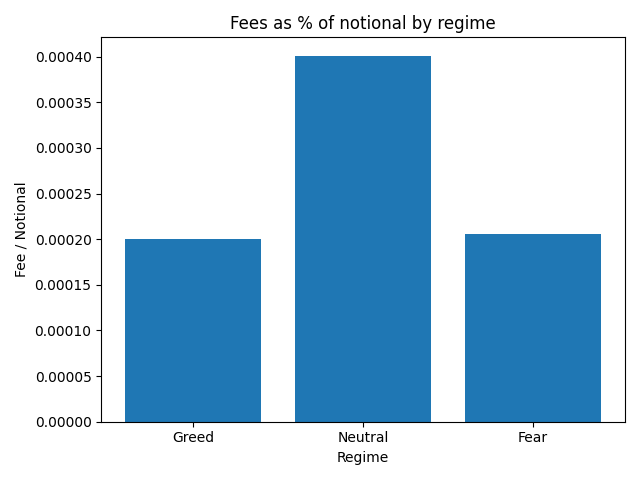


--- pnl_density_by_regime.png ---


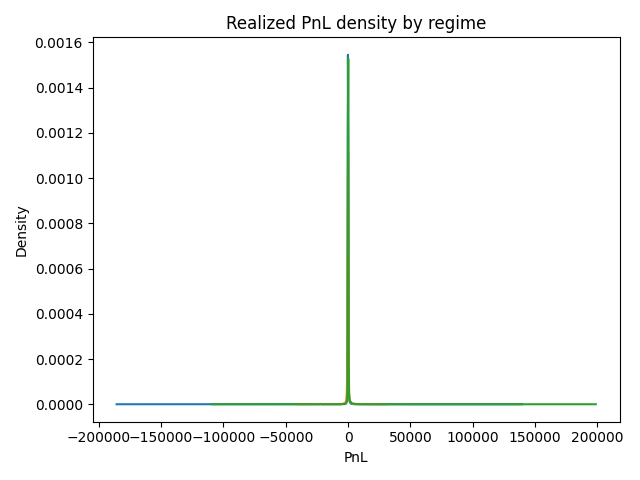


--- pnl_per_trade_by_regime.png ---


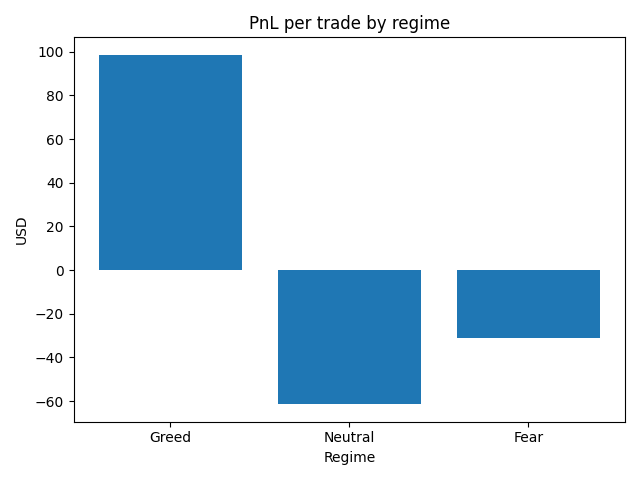


--- trades_per_hour_by_regime.png ---


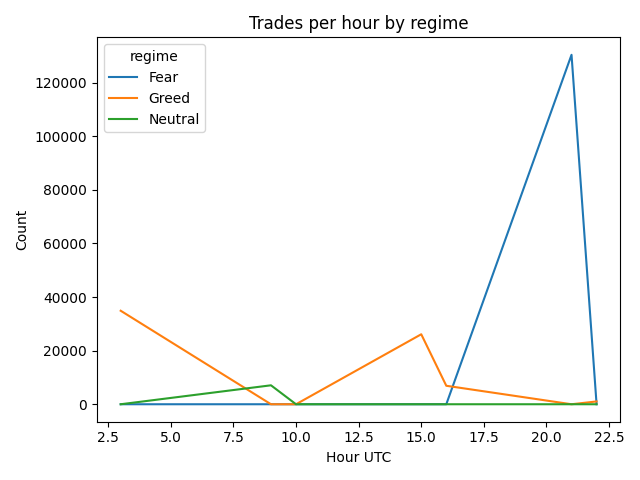


--- winrate_by_regime.png ---


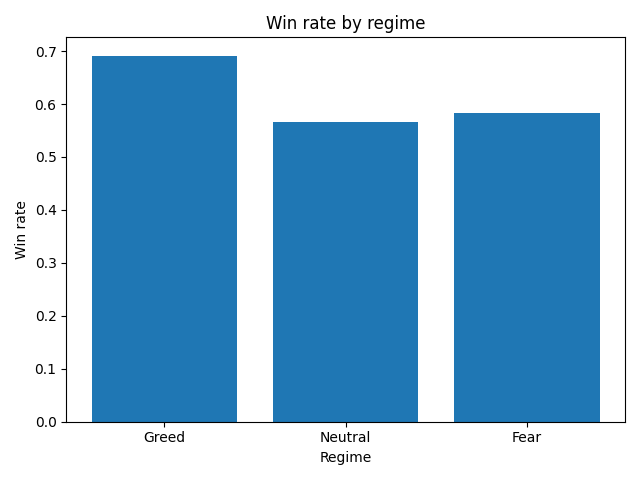

In [6]:
from IPython.display import Image, display
import os

output_dir = "outputs"
plot_files = [f for f in os.listdir(output_dir) if f.endswith(".png")]
plot_files.sort() # Display in a consistent order

if plot_files:
    print("Displaying generated plots:")
    for plot_file in plot_files:
        print(f"\n--- {plot_file} ---")
        display(Image(filename=os.path.join(output_dir, plot_file)))
else:
    print("No plot files found in the outputs directory.")